# SBI notebook - worked examples

In [1]:
# Load the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)


<div style="background-color:#C2F5DD">

## Exercises

### 4.1 Amortized inference
One great advantage of this approach is that we can use the trained classifier to perform inference on different observations, assuming that the experiment is performed under identical conditions. This means we do not need to re-run an expensive inference procedure each time. In other words, we have **amortized** the inference for future experiments. This becomes extremely useful when dealing with problems with extremely complex likelihoods.

We re-run the experiment, where $X \rightarrow aa$ decays are recorded over a longer period such that we obtain a larger dataset. This dataset can be found in `data_spin_extension.csv`. Your task is to repeat the hypothesis-test procedure using the larger dataset with the trained classifier. How do your conclusions change? Is this in line with what you expect from taking more data?

</div>

As we are in a separate notebook, we need to repeat the steps and retrain the classifier. In the main notebook you can (and should!) use the already trained classifier.

In [2]:
# Run the simulation
from sbi_utils import run_simulation
N_train = 100000
sim_H0 = run_simulation(N_train, hypothesis='H0')
sim_H1 = run_simulation(N_train, hypothesis='H1')

In [3]:
# Load extended data
data_obs = pd.read_csv('data_spin_extension.csv')
N_obs = len(data_obs)

In [6]:
# Build training dataset
sim_H0['label'] = 0
sim_H1['label'] = 1
sim = pd.concat([sim_H0, sim_H1], ignore_index=True)

# Split into test/train sets
test_size = 0.2
sim_train, sim_test = train_test_split(sim, test_size=test_size, shuffle=True)

# Convert to torch tensors
X_train = df_to_tensor(sim_train[['x1', 'x2', 'x3']])
y_train = df_to_tensor(sim_train[['label']])
X_test = df_to_tensor(sim_test[['x1', 'x2', 'x3']])
y_test = df_to_tensor(sim_test[['label']])

# Create DataLoader for batching
batch_size = 2048
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [7]:
# Define simple feedforward MLP with two hidden layers: input -> hidden -> hidden -> output (1)
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.sigmoid(self.fc3(out))
        return out

# Initialize model, loss function and optimizer
input_size = 3
hidden_size = 16
model = SimpleMLP(input_size, hidden_size)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [8]:
# Training loop: track loss per epoch for training and esting datasets
num_epochs = 50
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * inputs.size(0)
    epoch_test_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

Epoch [1/50], Train Loss: 0.6962, Test Loss: 0.6943
Epoch [2/50], Train Loss: 0.6925, Test Loss: 0.6905
Epoch [3/50], Train Loss: 0.6887, Test Loss: 0.6865
Epoch [4/50], Train Loss: 0.6843, Test Loss: 0.6817
Epoch [5/50], Train Loss: 0.6793, Test Loss: 0.6766
Epoch [6/50], Train Loss: 0.6741, Test Loss: 0.6715
Epoch [7/50], Train Loss: 0.6688, Test Loss: 0.6662
Epoch [8/50], Train Loss: 0.6634, Test Loss: 0.6608
Epoch [9/50], Train Loss: 0.6579, Test Loss: 0.6555
Epoch [10/50], Train Loss: 0.6525, Test Loss: 0.6504
Epoch [11/50], Train Loss: 0.6473, Test Loss: 0.6454
Epoch [12/50], Train Loss: 0.6424, Test Loss: 0.6408
Epoch [13/50], Train Loss: 0.6377, Test Loss: 0.6365
Epoch [14/50], Train Loss: 0.6335, Test Loss: 0.6326
Epoch [15/50], Train Loss: 0.6297, Test Loss: 0.6292
Epoch [16/50], Train Loss: 0.6264, Test Loss: 0.6263
Epoch [17/50], Train Loss: 0.6237, Test Loss: 0.6240
Epoch [18/50], Train Loss: 0.6214, Test Loss: 0.6221
Epoch [19/50], Train Loss: 0.6196, Test Loss: 0.6206
Ep

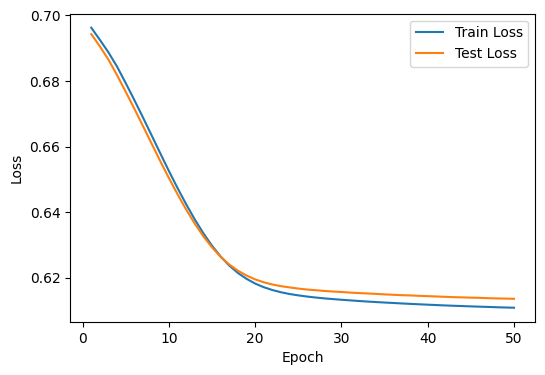

In [9]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
ax.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

Now the model has been trained, we will use this to perform a hypothesis test on the extended dataset. 

Crucially, the pseudo-experiments (toys) need to represent the observed data i.e. have $N_{obs}=50$ observations.

We will build up the test statistic distributions under the two hypotheses and compare this to the observed data. Following this we will follow the usual procedure of extracting the Type I and Type II errors.

In [10]:
def log_likelihood_ratio_torch(X, model, clip=1e-10):
    with torch.no_grad():
        scores = model(torch.tensor(X, dtype=torch.float32)).numpy().flatten()
    # Avoid log(0) by clipping scores
    scores = np.clip(scores, clip, 1-clip)
    llr = np.log(scores / (1 - scores))
    return llr

def test_statistic_torch(X, model):
    llr = log_likelihood_ratio_torch(X, model)
    return -2 * np.sum(llr)

In [12]:
N_toys = 10000
test_statistic_H0_clf = []
test_statistic_H1_clf = []
for _ in range(N_toys):
    # Samples under H0
    samples_H0 = run_simulation(N_obs, hypothesis='H0')
    t_H0_clf = test_statistic_torch(samples_H0[['x1', 'x2', 'x3']].values, model)
    test_statistic_H0_clf.append(t_H0_clf)

    # Samples under H1
    samples_H1 = run_simulation(N_obs, hypothesis='H1')
    t_H1_clf = test_statistic_torch(samples_H1[['x1', 'x2', 'x3']].values, model)
    test_statistic_H1_clf.append(t_H1_clf)

# Calculate observed test statistic
t_obs_clf = test_statistic_torch(data_obs[['x1', 'x2', 'x3']].values, model)

# Calculate the p-value for H0
p_value_H0_clf = np.sum(np.array(test_statistic_H0_clf) <= t_obs_clf) / N_toys

# Calculate the type-1 and type-2 errors for fixed alpha=0.05
alpha = 0.05
type_1_error = alpha
critical_value_clf = np.percentile(test_statistic_H0_clf, alpha * 100)
type_2_error_clf = np.sum(np.array(test_statistic_H1_clf) > critical_value_clf) / N_toys
power_clf = 1 - type_2_error_clf

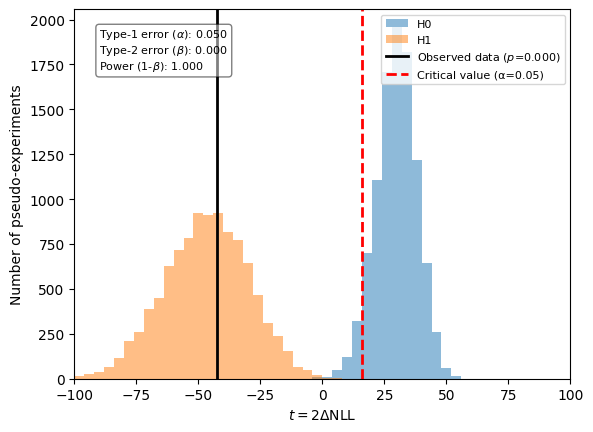

In [15]:
# Plot the test statistic distributions
fig, ax = plt.subplots()
ax.hist(test_statistic_H0_clf, bins=50, alpha=0.5, range=(-100,100), label='H0')
ax.hist(test_statistic_H1_clf, bins=50, alpha=0.5, range=(-100,100), label='H1')
ax.axvline(t_obs_clf, color='black', linestyle='solid', linewidth=2, label='Observed data ($p$={:.3f})'.format(p_value_H0_clf))
ax.axvline(critical_value_clf, color='red', linestyle='dashed', linewidth=2, label='Critical value (α={})'.format(alpha))
ax.set_xlabel('$t = 2\\Delta$NLL')
ax.set_xlim(-100, 100)
ax.set_ylabel('Number of pseudo-experiments')
ax.legend(loc='upper right', fontsize=8)
# Add text to plot with type-1, type-2 errors and power
textstr = '\n'.join((
    'Type-1 error ($\\alpha$): {:.3f}'.format(type_1_error),
    'Type-2 error ($\\beta$): {:.3f}'.format(type_2_error_clf),
    'Power (1-$\\beta$): {:.3f}'.format(power_clf)))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
plt.show()

What do you notice about the overlap of the test-statistic distributions with the additional data?

We can conclude with extremely high confidence that the data is inconsistent with the null hypothesis (Spin 0), and that particle $X$ is spin-one!

<div style="background-color:#C2F5DD">

### 4.2 Power of the statistical test
Above we evaluated the statistical power of the test statistic. Using `data_spin.csv` investigate how the power diminishes when you remove one of the observables e.g. $x_3$? Compare the ROC curves obtained with the 3D and 2D inputs? What does this tell us about the impact of adding more information on the ability to resolve the two hypotheses?

</div>

In [35]:
# Prepare simulation and observed datasets with only (x1,x2) features
data_obs = pd.read_csv('data_spin.csv')
N_obs = len(data_obs)
data_obs_reduced = data_obs[['x2', 'x3']]

In [36]:
# Train a classifier to distinguish H0 vs H1 using only (x1,x3)
X_train_reduced = df_to_tensor(sim_train[['x2', 'x3']])
y_train_reduced = df_to_tensor(sim_train[['label']])
X_test_reduced = df_to_tensor(sim_test[['x2', 'x3']])
y_test_reduced = df_to_tensor(sim_test[['label']])

# Create DataLoader for batching
train_dataset_reduced = TensorDataset(X_train_reduced, y_train_reduced)
train_loader_reduced = DataLoader(train_dataset_reduced, batch_size=batch_size, shuffle=True)
test_dataset_reduced = TensorDataset(X_test_reduced, y_test_reduced)
test_loader_reduced = DataLoader(test_dataset_reduced, batch_size=batch_size, shuffle=False)

# Initialize model with same architecture but input size 2
input_size_reduced = 2
model_reduced = SimpleMLP(input_size_reduced, hidden_size)
criterion_reduced = nn.BCELoss()
optimizer_reduced = torch.optim.Adam(model_reduced.parameters(), lr=0.0001)

In [37]:
# Training loop for reduced model
train_losses_reduced = []
test_losses_reduced = []
for epoch in range(num_epochs):
    model_reduced.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader_reduced:
        optimizer_reduced.zero_grad()
        outputs = model_reduced(inputs)
        loss = criterion_reduced(outputs, labels)
        loss.backward()
        optimizer_reduced.step()
        running_train_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_train_loss / len(train_loader_reduced.dataset)
    train_losses_reduced.append(epoch_train_loss)

    model_reduced.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader_reduced:
            outputs = model_reduced(inputs)
            loss = criterion_reduced(outputs, labels)
            running_test_loss += loss.item() * inputs.size(0)
    epoch_test_loss = running_test_loss / len(test_loader_reduced.dataset)
    test_losses_reduced.append(epoch_test_loss)

    print(f'Reduced Model Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

Reduced Model Epoch [1/50], Train Loss: 0.7119, Test Loss: 0.7081
Reduced Model Epoch [2/50], Train Loss: 0.7045, Test Loss: 0.7020
Reduced Model Epoch [3/50], Train Loss: 0.6995, Test Loss: 0.6977
Reduced Model Epoch [4/50], Train Loss: 0.6959, Test Loss: 0.6945
Reduced Model Epoch [5/50], Train Loss: 0.6930, Test Loss: 0.6918
Reduced Model Epoch [6/50], Train Loss: 0.6903, Test Loss: 0.6892
Reduced Model Epoch [7/50], Train Loss: 0.6878, Test Loss: 0.6867
Reduced Model Epoch [8/50], Train Loss: 0.6853, Test Loss: 0.6842
Reduced Model Epoch [9/50], Train Loss: 0.6828, Test Loss: 0.6817
Reduced Model Epoch [10/50], Train Loss: 0.6803, Test Loss: 0.6792
Reduced Model Epoch [11/50], Train Loss: 0.6778, Test Loss: 0.6765
Reduced Model Epoch [12/50], Train Loss: 0.6752, Test Loss: 0.6740
Reduced Model Epoch [13/50], Train Loss: 0.6729, Test Loss: 0.6718
Reduced Model Epoch [14/50], Train Loss: 0.6708, Test Loss: 0.6699
Reduced Model Epoch [15/50], Train Loss: 0.6689, Test Loss: 0.6681
Redu

Perform hypothesis test using the 3D model and the 2D model. Compare the test statistic distributions.

In [38]:
N_toys = 10000
test_statistic_H0_clf_reduced = []
test_statistic_H1_clf_reduced = []
test_statistic_H0_clf = []
test_statistic_H1_clf = []
for _ in range(N_toys):
    # Samples under H0
    samples_H0 = run_simulation(N_obs, hypothesis='H0')
    t_H0_clf_reduced = test_statistic_torch(samples_H0[['x2', 'x3']].values, model_reduced)
    test_statistic_H0_clf_reduced.append(t_H0_clf_reduced)
    t_H0_clf = test_statistic_torch(samples_H0[['x1', 'x2', 'x3']].values, model)
    test_statistic_H0_clf.append(t_H0_clf)

    # Samples under H1
    samples_H1 = run_simulation(N_obs, hypothesis='H1')
    t_H1_clf_reduced = test_statistic_torch(samples_H1[['x2', 'x3']].values, model_reduced)
    test_statistic_H1_clf_reduced.append(t_H1_clf_reduced)
    t_H1_clf = test_statistic_torch(samples_H1[['x1', 'x2', 'x3']].values, model)
    test_statistic_H1_clf.append(t_H1_clf)

# Calculate observed test statistic for models
t_obs_clf_reduced = test_statistic_torch(data_obs_reduced[['x2', 'x3']].values, model_reduced)
t_obs_clf = test_statistic_torch(data_obs[['x1', 'x2', 'x3']].values, model)

# Calculate the p-value for H0 for both models
p_value_H0_clf_reduced = np.sum(np.array(test_statistic_H0_clf_reduced) <= t_obs_clf_reduced) / N_toys
p_value_H0_clf = np.sum(np.array(test_statistic_H0_clf) <= t_obs_clf) / N_toys

In [39]:
# We can compute the power of the tests for both models at fixed alpha=0.05
alpha = 0.05
critical_value_clf_reduced = np.percentile(test_statistic_H0_clf_reduced, alpha * 100)
critical_value_clf = np.percentile(test_statistic_H0_clf, alpha * 100)
type_2_error_clf_reduced = np.sum(np.array(test_statistic_H1_clf_reduced) > critical_value_clf_reduced) / N_toys
type_2_error_clf = np.sum(np.array(test_statistic_H1_clf) > critical_value_clf) / N_toys
power_clf_reduced = 1 - type_2_error_clf_reduced
power_clf = 1 - type_2_error_clf

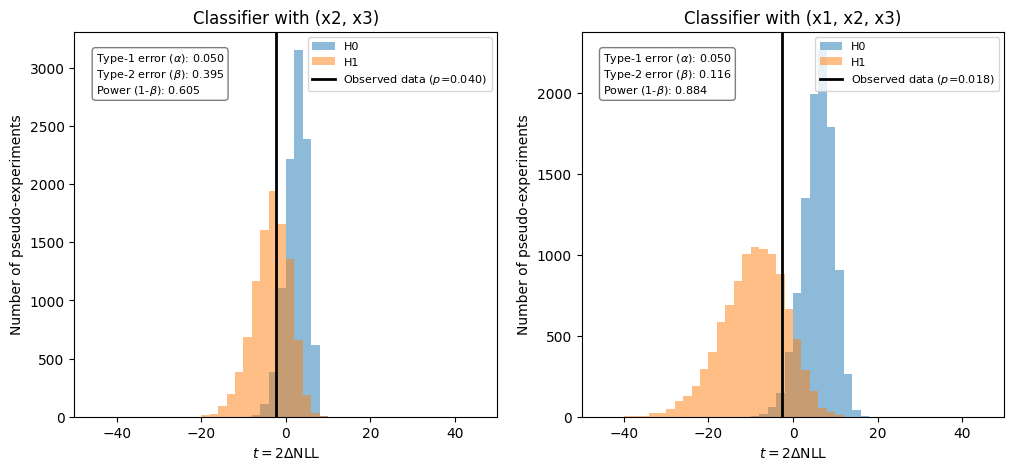

In [40]:
# Plot the test statistic distributions for both models side-by-side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Reduced model plot
axs[0].hist(test_statistic_H0_clf_reduced, bins=50, alpha=0.5, range=(-50,50), label='H0')
axs[0].hist(test_statistic_H1_clf_reduced, bins=50, alpha=0.5, range=(-50,50), label='H1')
axs[0].axvline(t_obs_clf_reduced, color='black', linestyle='solid', linewidth=2, label='Observed data ($p$={:.3f})'.format(p_value_H0_clf_reduced))
axs[0].set_title('Classifier with (x2, x3)')
axs[0].set_xlabel('$t = 2\\Delta$NLL')
axs[0].set_xlim(-50, 50)
axs[0].set_ylabel('Number of pseudo-experiments')
axs[0].legend(loc='upper right', fontsize=8)
# Add text to reduced model plot with type-1, type-2 errors and power
textstr_reduced = '\n'.join((
    'Type-1 error ($\\alpha$): {:.3f}'.format(type_1_error),
    'Type-2 error ($\\beta$): {:.3f}'.format(type_2_error_clf_reduced),
    'Power (1-$\\beta$): {:.3f}'.format(power_clf_reduced)))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
axs[0].text(0.05, 0.95, textstr_reduced, transform=axs[0].transAxes, fontsize=8,
        verticalalignment='top', bbox=props)

# Full model plot
axs[1].hist(test_statistic_H0_clf, bins=50, alpha=0.5, range=(-50,50), label='H0')
axs[1].hist(test_statistic_H1_clf, bins=50, alpha=0.5, range=(-50,50), label='H1')
axs[1].axvline(t_obs_clf, color='black', linestyle='solid', linewidth=2, label='Observed data ($p$={:.3f})'.format(p_value_H0_clf))
axs[1].set_title('Classifier with (x1, x2, x3)')
axs[1].set_xlabel('$t = 2\\Delta$NLL')
axs[1].set_xlim(-50, 50)
axs[1].set_ylabel('Number of pseudo-experiments')
axs[1].legend(loc='upper right', fontsize=8)
# Add text to full model plot with type-1, type-2 errors and power
textstr_full = '\n'.join((
    'Type-1 error ($\\alpha$): {:.3f}'.format(type_1_error),
    'Type-2 error ($\\beta$): {:.3f}'.format(type_2_error_clf),
    'Power (1-$\\beta$): {:.3f}'.format(power_clf)))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
axs[1].text(0.05, 0.95, textstr_full, transform=axs[1].transAxes, fontsize=8,
        verticalalignment='top', bbox=props)

plt.show()



As expected, the power of the statistical test has diminished when we remove information. Let's show this explicitly with ROC curves.

/var/folders/s8/tv6fkxk54c504yvk1cld2tn40000gp/T/ipykernel_24199/2902847411.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_reduced = np.trapz(tpr_reduced, fpr)
/var/folders/s8/tv6fkxk54c504yvk1cld2tn40000gp/T/ipykernel_24199/2902847411.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_full = np.trapz(tpr_full, fpr)


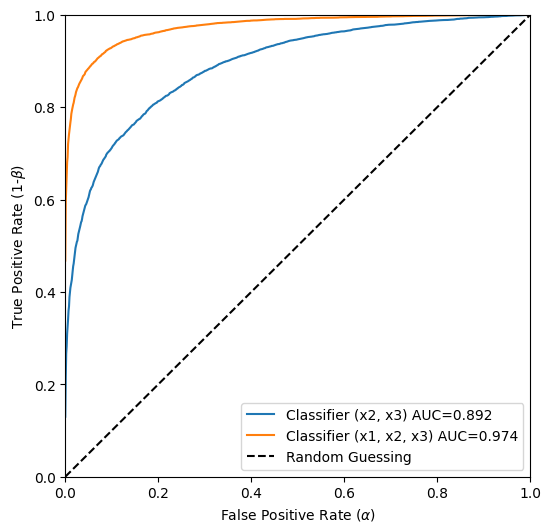

In [41]:
# ROC curves for both models
alpha_vals = np.linspace(0, 1, 1000)
beta_vals_reduced = []
beta_vals_full = []
for alpha in alpha_vals:
    critical_value_reduced = np.percentile(test_statistic_H0_clf_reduced, alpha * 100)
    beta_reduced = np.sum(np.array(test_statistic_H1_clf_reduced) > critical_value_reduced) / N_toys
    beta_vals_reduced.append(beta_reduced)

    critical_value_full = np.percentile(test_statistic_H0_clf, alpha * 100)
    beta_full = np.sum(np.array(test_statistic_H1_clf) > critical_value_full) / N_toys
    beta_vals_full.append(beta_full)

fpr = alpha_vals
tpr_reduced = 1 - np.array(beta_vals_reduced)
tpr_full = 1 - np.array(beta_vals_full)

# Calculate AUC using trapezoid rule
auc_reduced = np.trapezoid(tpr_reduced, fpr)
auc_full = np.trapezoid(tpr_full, fpr)

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(fpr, tpr_reduced, label='Classifier (x2, x3) AUC={:.3f}'.format(auc_reduced))
ax.plot(fpr, tpr_full, label='Classifier (x1, x2, x3) AUC={:.3f}'.format(auc_full))
ax.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
ax.set_xlabel('False Positive Rate ($\\alpha$)')
ax.set_ylabel('True Positive Rate (1-$\\beta$)')
ax.legend(loc='best')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.show()


<div style="background-color:#C2F5DD">

### 5.1 Improving the accuracy of the parameter estimation
In the main notebook the "learned" test statistic shows some deviations from the analytic solution. This could lead to biases (or incorrect conclusions) when using the ML SBI approach. Can you improve the accuracy by altering the model training? One could consider:
* Increasing the amount of training data
* Increasing the granularity of the $(\mu_2,\rho_{12})$ grid used for the training
* Extending to a more complex model arhcitecture

Reproduce the plots at the end of this section to see how your changes affect the accuracy.

</div>

In [61]:
# Define (same) function for running simulation
def run_simulation(N, mu1=0, sigma1=1, mu2=0, sigma2=1, rho12=0):
    cov_matrix = [[sigma1**2, rho12 * sigma1 * sigma2],
                  [rho12 * sigma1 * sigma2, sigma2**2]]
    data = np.random.multivariate_normal(mean=[mu1, mu2], cov=cov_matrix, size=N)
    df = pd.DataFrame(data, columns=['x1', 'x2'])
    return df

# Define function for analytical log-likelihood ratio test statistic
def log_likelihood_ratio_analytic(x, params, params_ref):
    mu1, sigma1, mu2, sigma2, rho12 = params
    mu1_ref, sigma1_ref, mu2_ref, sigma2_ref, rho12_ref = params_ref

    cov_matrix = np.array([[sigma1**2, rho12 * sigma1 * sigma2],
                           [rho12 * sigma1 * sigma2, sigma2**2]])
    cov_matrix_ref = np.array([[sigma1_ref**2, rho12_ref * sigma1_ref * sigma2_ref],
                               [rho12_ref * sigma1_ref * sigma2_ref, sigma2_ref**2]])
    
    inv_cov = np.linalg.inv(cov_matrix)
    inv_cov_ref = np.linalg.inv(cov_matrix_ref)
    
    diff = x - np.array([mu1, mu2])
    diff_ref = x - np.array([mu1_ref, mu2_ref])

    ll = -0.5 * np.einsum('ij,jk,ik->i', diff, inv_cov, diff) - 0.5 * np.log(np.linalg.det(cov_matrix)) - np.log(2 * np.pi)
    ll_ref = -0.5 * np.einsum('ij,jk,ik->i', diff_ref, inv_cov_ref, diff_ref) - 0.5 * np.log(np.linalg.det(cov_matrix_ref)) - np.log(2 * np.pi)
    return ll-ll_ref

# Function to calculate log-likelihood ratio using the trained parametric classifier
def log_likelihood_ratio_parameterized(X, mu2_eval, rho12_eval, model, clip=1e-10):
    N = X.shape[0]
    mu2_array = np.full(N, mu2_eval)
    rho12_array = np.full(N, rho12_eval)
    input_array = np.column_stack((X, mu2_array, rho12_array))
    with torch.no_grad():
        scores = model(torch.tensor(input_array, dtype=torch.float32)).numpy().flatten()
    # Avoid log(0) by clipping scores
    scores = np.clip(scores, clip, 1-clip)
    llr = np.log(scores / (1 - scores))
    return llr

# Define function to convert pandas dataframe to a torch tensor
def df_to_torch_tensor(df, feature_cols):
    return torch.tensor(df[feature_cols].values, dtype=torch.float32)

In [46]:
# Include synthetic training data by factor of 10 to 1 million
num_train_per_class = 1000000

# Generate synthetic data for reference sample (H0)
sim_H0 = run_simulation(num_train_per_class, mu1=0, sigma1=1, mu2=0, sigma2=1, rho12=0)
sim_H0['label'] = 0

In [47]:
# Increase granularity of H1 simulations by factor 2 (50->100 per dimension)
sim_H1_ensemble = []
mu2_train_vals = np.linspace(-1,1,100)
rho12_train_vals = np.linspace(-0.9999,0.9999,100)
num_train_per_subsample = num_train_per_class // (len(mu2_train_vals) * len(rho12_train_vals))

for mu2 in mu2_train_vals:
    for rho12 in rho12_train_vals:
        sim_H1_subsample = run_simulation(num_train_per_subsample, mu1=0, sigma1=1, mu2=mu2, sigma2=1, rho12=rho12)
        sim_H1_subsample['mu2'] = mu2
        sim_H1_subsample['rho12'] = rho12
        sim_H1_ensemble.append(sim_H1_subsample)
    
# Concatenate all subsamples into single dataframe and add label
sim_H1 = pd.concat(sim_H1_ensemble, ignore_index=True)
sim_H1['label'] = 1

In [48]:
# Align conditional parameter distributions between H0 and H1
sim_H0['mu2'] = np.random.choice(mu2_train_vals, size=len(sim_H0))
sim_H0['rho12'] = np.random.choice(rho12_train_vals, size=len(sim_H0))

In [51]:
# Combine datasets and split into train/test sets
sim = pd.concat([sim_H0, sim_H1], ignore_index=True)
test_size = 0.2
sim_train, sim_test = train_test_split(sim, test_size=test_size, shuffle=True)

# Convert to torch tensors
feature_cols = ['x1', 'x2', 'mu2', 'rho12']
X_train = df_to_torch_tensor(sim_train, feature_cols)
y_train = df_to_torch_tensor(sim_train, ['label'])
X_test = df_to_torch_tensor(sim_test, feature_cols)
y_test = df_to_torch_tensor(sim_test, ['label'])
# Create DataLoader for batching
batch_size = 2048
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [57]:
# Define MLP model and increase number of hidden layers and size of hidden layers
class ParameterizedMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layers=2):
        super(ParameterizedMLP, self).__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, 1))
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)
    
# Initialize model, loss function and optimizer
input_size = len(feature_cols)
hidden_size = 512
num_hidden_layers = 4
model_param = ParameterizedMLP(input_size, hidden_size, num_hidden_layers)
criterion_param = nn.BCELoss()
optimizer_param = torch.optim.Adam(model_param.parameters(), lr=0.0001)

In [ ]:
# Training loop for parameterized model
num_epochs = 50
train_losses_param = []
test_losses_param = []
for epoch in range(num_epochs):
    model_param.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer_param.zero_grad()
        outputs = model_param(inputs)
        loss = criterion_param(outputs, labels)
        loss.backward()
        optimizer_param.step()
        running_train_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses_param.append(epoch_train_loss)

    model_param.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model_param(inputs)
            loss = criterion_param(outputs, labels)
            running_test_loss += loss.item() * inputs.size(0)
    epoch_test_loss = running_test_loss / len(test_loader.dataset)
    test_losses_param.append(epoch_test_loss)

    print(f'Param Model Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

Param Model Epoch [1/20], Train Loss: 0.5951, Test Loss: 0.5832
Param Model Epoch [2/20], Train Loss: 0.5821, Test Loss: 0.5802
Param Model Epoch [3/20], Train Loss: 0.5803, Test Loss: 0.5802
Param Model Epoch [4/20], Train Loss: 0.5795, Test Loss: 0.5795
Param Model Epoch [5/20], Train Loss: 0.5790, Test Loss: 0.5785
Param Model Epoch [6/20], Train Loss: 0.5786, Test Loss: 0.5797
Param Model Epoch [7/20], Train Loss: 0.5782, Test Loss: 0.5800
Param Model Epoch [8/20], Train Loss: 0.5780, Test Loss: 0.5786
Param Model Epoch [9/20], Train Loss: 0.5777, Test Loss: 0.5779
Param Model Epoch [10/20], Train Loss: 0.5775, Test Loss: 0.5778
Param Model Epoch [11/20], Train Loss: 0.5774, Test Loss: 0.5782
Param Model Epoch [12/20], Train Loss: 0.5772, Test Loss: 0.5775
Param Model Epoch [13/20], Train Loss: 0.5772, Test Loss: 0.5770
Param Model Epoch [14/20], Train Loss: 0.5769, Test Loss: 0.5767
Param Model Epoch [15/20], Train Loss: 0.5768, Test Loss: 0.5776
Param Model Epoch [16/20], Train L

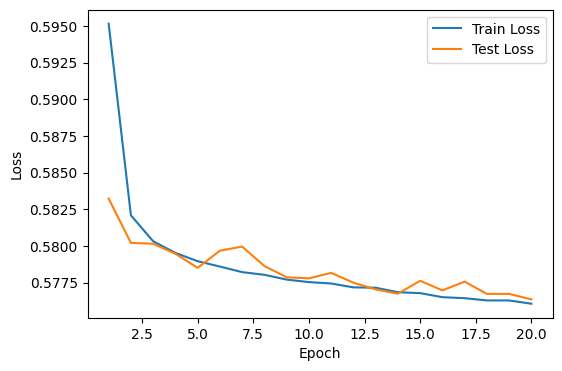

In [59]:
# Plot training and testing loss curves for parameterized model
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(range(1, len(train_losses_param)+1), train_losses_param, label='Train Loss')
ax.plot(range(1, len(test_losses_param)+1), test_losses_param, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [64]:
# Load observed data
data_obs = pd.read_csv('data_parameter_estimation.csv')

In [72]:
# Scan over (mu2, rho12) grid to compute test statistic values for both analytic and parameterized methods
mu2_vals = np.linspace(-1, 1, 100)
rho12_vals = np.linspace(-0.9999, 0.9999, 100)
llr_vals_analytic = np.zeros((len(mu2_vals), len(rho12_vals)))
llr_vals_param = np.zeros((len(mu2_vals), len(rho12_vals)))
for i, mu2 in enumerate(mu2_vals):
    for j, rho12 in enumerate(rho12_vals):
        params = (0, 1, mu2, 1, rho12)
        params_ref = (0, 1, 0, 1, 0)
        llr_analytic = log_likelihood_ratio_analytic(data_obs[['x1', 'x2']].values, params, params_ref)
        llr_vals_analytic[i, j] = np.sum(llr_analytic)

        llr_param = log_likelihood_ratio_parameterized(data_obs[['x1', 'x2']].values, mu2, rho12, model_param)
        llr_vals_param[i, j] = np.sum(llr_param)

# Convert llr to test statistic 2NLL
test_statistic_analytic = -2 * (llr_vals_analytic - np.max(llr_vals_analytic))
test_statistic_param = -2 * (llr_vals_param - np.max(llr_vals_param))

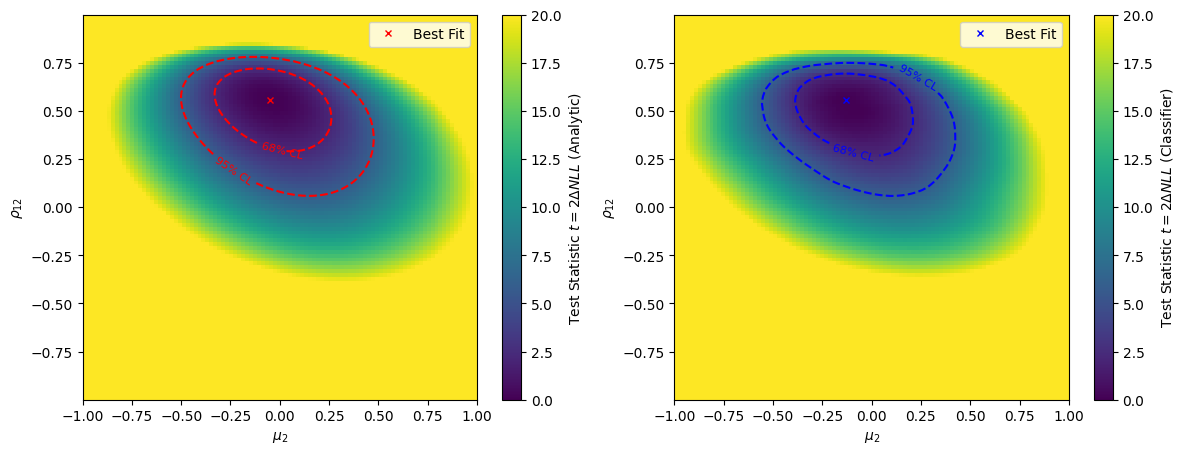

In [73]:
# Plot test statistic heatmap from parametrised classifier next to analytic solution
fig, ax = plt.subplots(1, 2, figsize=(14,5))
c1 = ax[0].imshow(test_statistic_analytic.T, extent=[mu2_vals[0], mu2_vals[-1], rho12_vals[0], rho12_vals[-1]],
              origin='lower', aspect='auto', cmap='viridis', vmin=0, vmax=20)
ax[0].set_xlabel(r'$\mu_2$')
ax[0].set_ylabel(r'$\rho_{12}$')
fig.colorbar(c1, ax=ax[0], label=r'Test Statistic $t = 2\Delta NLL$ (Analytic)')
contours1 = ax[0].contour(mu2_vals, rho12_vals, test_statistic_analytic.T, levels=[2.30, 5.99], colors='red', linestyles='dashed')
ax[0].clabel(contours1, inline=True, fontsize=8, fmt={2.30: '68% CL', 5.99: '95% CL'})
min_idx_analytic = np.unravel_index(np.argmin(test_statistic_analytic), test_statistic_analytic.shape)
ax[0].plot(mu2_vals[min_idx_analytic[0]], rho12_vals[min_idx_analytic[1]], marker='x', color='red', markersize=5, label='Best Fit', linestyle='None')
ax[0].legend()

c2 = ax[1].imshow(test_statistic_param.T, extent=[mu2_vals[0], mu2_vals[-1], rho12_vals[0], rho12_vals[-1]],
                origin='lower', aspect='auto', cmap='viridis', vmin=0, vmax=20)
ax[1].set_xlabel(r'$\mu_2$')
ax[1].set_ylabel(r'$\rho_{12}$')
fig.colorbar(c2, ax=ax[1], label=r'Test Statistic $t = 2\Delta NLL$ (Classifier)')
contours2 = ax[1].contour(mu2_vals, rho12_vals, test_statistic_param.T, levels=[2.30, 5.99], colors='blue', linestyles='dashed')
ax[1].clabel(contours2, inline=True, fontsize=8, fmt={2.30: '68% CL', 5.99: '95% CL'})
min_idx_clf = np.unravel_index(np.argmin(test_statistic_param), test_statistic_param.shape)
ax[1].plot(mu2_vals[min_idx_clf[0]], rho12_vals[min_idx_clf[1]], marker='x', color='blue', markersize=5, label='Best Fit', linestyle='None')
ax[1].legend()

plt.show()

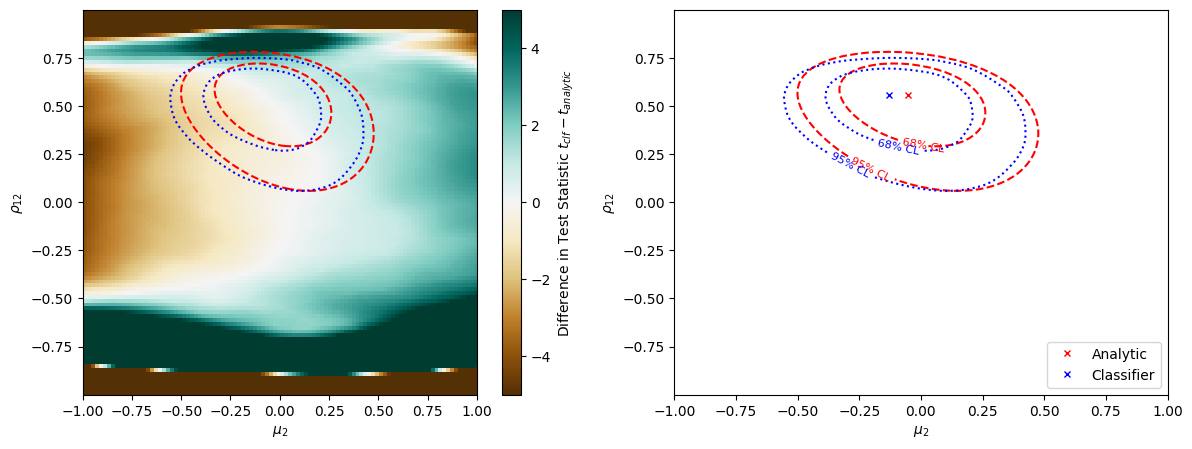

In [74]:
# Plot difference of test-statistic heatmaps next to plot with all contours on same axis
fig, ax = plt.subplots(1, 2, figsize=(14,5))
diff_test_statistic = test_statistic_param - test_statistic_analytic
c = ax[0].imshow(diff_test_statistic.T, extent=[mu2_vals[0], mu2_vals[-1], rho12_vals[0], rho12_vals[-1]],
              origin='lower', aspect='auto', cmap='BrBG', vmin=-5, vmax=5)
ax[0].set_xlabel(r'$\mu_2$')
ax[0].set_ylabel(r'$\rho_{12}$')
fig.colorbar(c, ax=ax[0], label=r'Difference in Test Statistic $t_{clf} - t_{analytic}$')
# Add contours for reference
contours_analytic = ax[0].contour(mu2_vals, rho12_vals, test_statistic_analytic.T, levels=[2.30, 5.99], colors='red', linestyles='dashed')
contours_clf = ax[0].contour(mu2_vals, rho12_vals, test_statistic_param.T, levels=[2.30, 5.99], colors='blue', linestyles='dotted')

# Plot all contours on same axis
ax[1].set_xlabel(r'$\mu_2$')
ax[1].set_ylabel(r'$\rho_{12}$')
contours_analytic = ax[1].contour(mu2_vals, rho12_vals, test_statistic_analytic.T, levels=[2.30, 5.99], colors='red', linestyles='dashed')
ax[1].clabel(contours_analytic, inline=True, fontsize=8, fmt={2.30: '68% CL', 5.99: '95% CL'})
contours_clf = ax[1].contour(mu2_vals, rho12_vals, test_statistic_param.T, levels=[2.30, 5.99], colors='blue', linestyles='dotted')
ax[1].clabel(contours_clf, inline=True, fontsize=8, fmt={2.30: '68% CL', 5.99: '95% CL'})
ax[1].plot(mu2_vals[min_idx_analytic[0]], rho12_vals[min_idx_analytic[1]], marker='x', color='red', markersize=5, label='Analytic', linestyle='None')
ax[1].plot(mu2_vals[min_idx_clf[0]], rho12_vals[min_idx_clf[1]], marker='x', color='blue', markersize=5, label='Classifier', linestyle='None')
ax[1].legend(loc='lower right')

plt.show()

With a larger training sample, a finer grid, and a larger model architecture we are able to reproduce the confidence intervals with greater accuracy!

<div style="background-color:#C2F5DD">

### 5.2 Amortized inference
As before, we can use the trained parametric classifier to perform inference on new observations. Try generating data for a particular $(\mu_2,\rho_{12})$ set, starting with $N=20$ samples, and perform inference on this new dataset. Then generate $N=50$ samples and repeat the inference. How do the confidence intervals change? Is the "true" value used to generate the samples consistent with the results? How does this change for $N=100$, $N=500$ etc? Do you eventually observe a sizeable bias in the results?

</div>

In [76]:
# Define true values of parameters
mu2_true = -0.1
rho12_true = 0.3

# Generate pseudo-experiments and compute test statistic at true parameter values
N_obs_vals = [10, 20, 50, 100, 500]
data_obs = {}
for N_obs in N_obs_vals:
    data_obs[N_obs] = run_simulation(N_obs, mu1=0, sigma1=1, mu2=mu2_true, sigma2=1, rho12=rho12_true)

In [80]:
# Compute test statistic grid for both analytic and parameterized methods for each N_obs
mu2_vals = np.linspace(-1, 1, 100)
rho12_vals = np.linspace(-0.9999, 0.9999, 100)

test_statistic_analytic_obs = {}
test_statistic_param_obs = {}
llr_vals_analytic_obs = {}
llr_vals_param_obs = {}

for N_obs in N_obs_vals:
    llr_vals_analytic_obs[N_obs] = np.zeros((len(mu2_vals), len(rho12_vals)))
    llr_vals_param_obs[N_obs] = np.zeros((len(mu2_vals), len(rho12_vals)))

for i, mu2 in enumerate(mu2_vals):
    for j, rho12 in enumerate(rho12_vals):
        params = (0, 1, mu2, 1, rho12)
        params_ref = (0, 1, 0, 1, 0)
        for N_obs in N_obs_vals:
            llr_analytic = log_likelihood_ratio_analytic(data_obs[N_obs][['x1', 'x2']].values, params, params_ref)
            llr_vals_analytic_obs[N_obs][i, j] = np.sum(llr_analytic)

            llr_param = log_likelihood_ratio_parameterized(data_obs[N_obs][['x1', 'x2']].values, mu2, rho12, model_param)
            llr_vals_param_obs[N_obs][i, j] = np.sum(llr_param)

for N_obs in N_obs_vals:
    test_statistic_analytic_obs[N_obs] = -2 * (llr_vals_analytic_obs[N_obs] - np.max(llr_vals_analytic_obs[N_obs]))
    test_statistic_param_obs[N_obs] = -2 * (llr_vals_param_obs[N_obs] - np.max(llr_vals_param_obs[N_obs]))

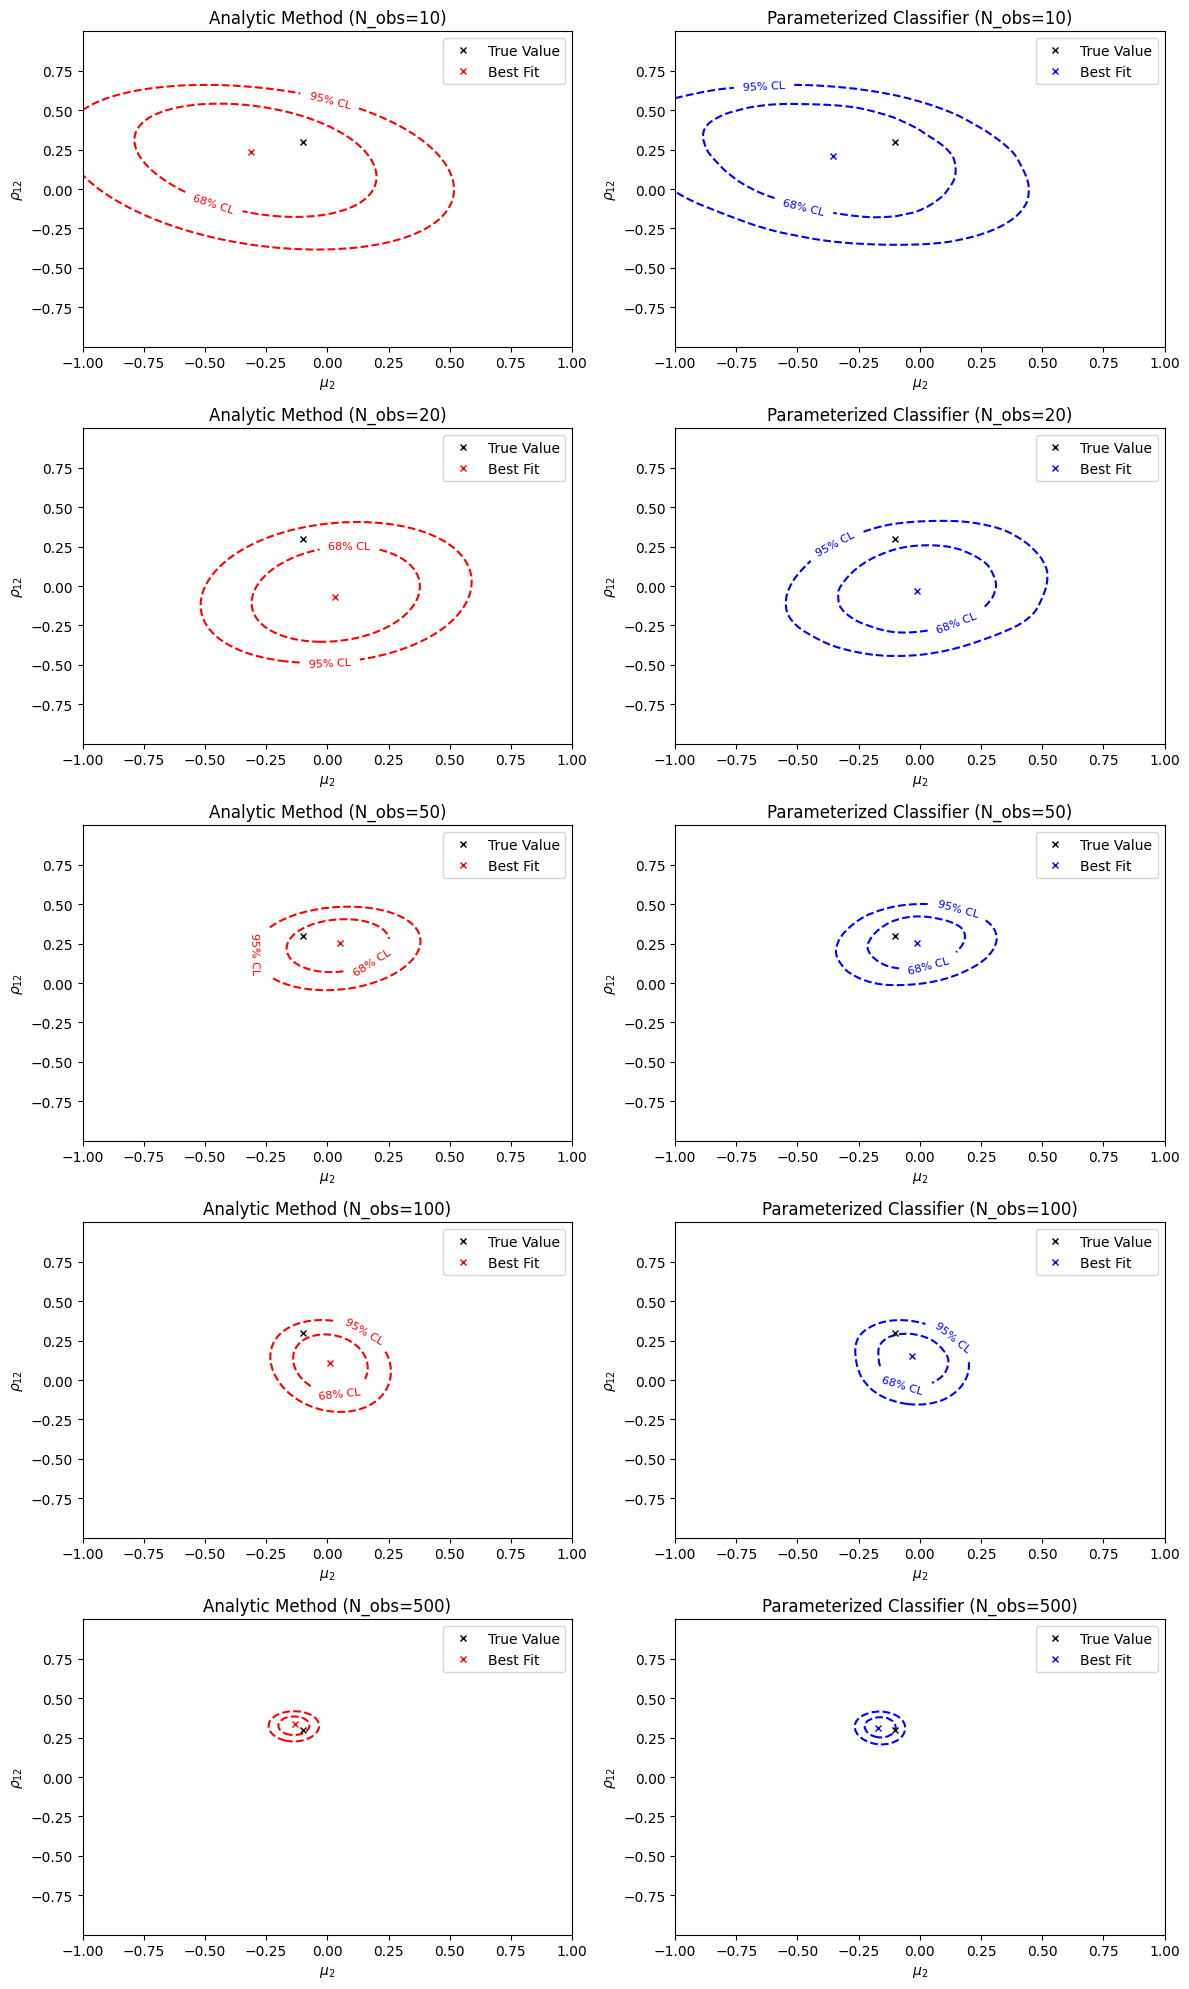

In [81]:
# Compare confidence interval contours for both methods at different N_obs
fig, axs = plt.subplots(len(N_obs_vals), 2, figsize=(12, 4*len(N_obs_vals)))
for idx, N_obs in enumerate(N_obs_vals):
    # Analytic method
    axs[idx, 0].set_title(f'Analytic Method (N_obs={N_obs})')
    axs[idx, 0].set_xlabel(r'$\mu_2$')
    axs[idx, 0].set_ylabel(r'$\rho_{12}$')
    contours1 = axs[idx, 0].contour(mu2_vals, rho12_vals, test_statistic_analytic_obs[N_obs].T, levels=[2.30, 5.99], colors='red', linestyles='dashed')
    axs[idx, 0].clabel(contours1, inline=True, fontsize=8, fmt={2.30: '68% CL', 5.99: '95% CL'})
    # Add marker for true parameter values
    axs[idx, 0].plot(mu2_true, rho12_true, marker='x', color='black', markersize=5, label='True Value', linestyle='None')
    # Add marker for best-fit parameter values
    min_idx_analytic = np.unravel_index(np.argmin(test_statistic_analytic_obs[N_obs]), test_statistic_analytic_obs[N_obs].shape)
    axs[idx, 0].plot(mu2_vals[min_idx_analytic[0]], rho12_vals[min_idx_analytic[1]], marker='x', color='red', markersize=5, label='Best Fit', linestyle='None')
    axs[idx, 0].legend()

    # Parameterized method
    axs[idx, 1].set_title(f'Parameterized Classifier (N_obs={N_obs})')
    axs[idx, 1].set_xlabel(r'$\mu_2$')
    axs[idx, 1].set_ylabel(r'$\rho_{12}$')
    contours2 = axs[idx, 1].contour(mu2_vals, rho12_vals, test_statistic_param_obs[N_obs].T, levels=[2.30, 5.99], colors='blue', linestyles='dashed')
    axs[idx, 1].clabel(contours2, inline=True, fontsize=8, fmt={2.30: '68% CL', 5.99: '95% CL'})
    # Add marker for true parameter values
    axs[idx, 1].plot(mu2_true, rho12_true, marker='x', color='black', markersize=5, label='True Value', linestyle='None')
    # Add marker for best-fit parameter values
    min_idx_param = np.unravel_index(np.argmin(test_statistic_param_obs[N_obs]), test_statistic_param_obs[N_obs].shape)
    axs[idx, 1].plot(mu2_vals[min_idx_param[0]], rho12_vals[min_idx_param[1]], marker='x', color='blue', markersize=5, label='Best Fit', linestyle='None')
    axs[idx, 1].legend()
plt.tight_layout()

The parametric model can be used for amortized inference. With N=500, we still do not see a large bias. Perhaps go even further (you will need to reduce the axis range to see the contours properly).